<h1 style="margin: 0; padding: 0; color: #d9f4e4;">Pre Preparing<h1/>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/v1.zip

Archive:  /content/drive/MyDrive/v1.zip
  inflating: v1/AMAZON_FASHION.json  
  inflating: v1/meta_AMAZON_FASHION.json  


In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.3 MB/s eta 0:00:00


<h1 style="margin: 0; padding: 0; color: #d9f4e4;">Import Libraries<h1/>

In [ ]:
import glob
import pandas as pd
import re
import html
from sentence_transformers import SentenceTransformer
import numpy as np
import os
import faiss
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

<h1 style="margin: 0; padding: 0; color: #d9f4e4;">Global Variables<h1/>

In [ ]:
# PATH = "/kaggle/input/hyb-reco-amazone/Dataset"
FASHION_FILE = "/content/v1/AMAZON_FASHION.json"
META_FILE = "/content/v1/meta_AMAZON_FASHION.json"

In [ ]:
TEXT_COLS = ["title", "brand", "description", "feature", "summary", "reviewText", "details", "fit", "rank", "tech1"]
LIST_COLS = ["title", "des", "similar_item"]
IMAGE_COLS = ["imageURL", "imageURLHighRes"]
NEEDED_COLS = ["asin", "title", "brand", "description", "feature", "details", "fit", "reviewText", "summary", "imageURL", "price", "overall"]

In [ ]:
MODEL_NAME = "BAAI/bge-large-en-v1.5"
CHUNK_SIZE = 10_000
EMB_DIR = "/content/wokring"
PROGRESS_FILE = "/content/wokring/progress.txt"

In [ ]:
os.makedirs(EMB_DIR, exist_ok=True)

<h1 style="margin: 0; padding: 0; color: #d9f4e4;">Functions<h1/>

In [ ]:
def normalize_list_field(x):
    if isinstance(x, list):
        return " ".join(str(i) for i in x if i is not None)
    if pd.isna(x):
        return ""
    return str(x)

In [ ]:
def clean(text):
    if text is None:
        return ""
    text = str(text)
    text = html.unescape(text)

    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www.\S+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [ ]:
def semantic_search(query, model, index, df, top_k=5):
    query_embedding = model.encode(
        [query],
        normalize_embeddings=True
    )

    scores, indices = index.search(query_embedding, top_k)

    results = []
    for idx, score in zip(indices[0], scores[0]):
        item = df.iloc[idx]
        results.append({
            "asin": item["asin"],
            "title": item["title"],
            "brand": item["brand"],
            "score": float(score)
        })

    return results

In [ ]:
def semantic_search_points(query, model, embeddings, df, top_k=5):
    query_emb = model.encode(
        [query],
        normalize_embeddings=True
    )

    scores = cosine_similarity(query_emb, embeddings)[0]

    top_idx = np.argsort(scores)[::-1][:top_k]

    results = df.iloc[top_idx].copy()
    results["score"] = scores[top_idx]

    return results

<h1 style="margin: 0; padding: 0; color: #d9f4e4;">Import data & Display Data<h1/>

In [ ]:
fashion_path = FASHION_FILE
meta_path = META_FILE

In [ ]:
fashion_df = pd.read_json(fashion_path, lines=True)
meta_df = pd.read_json(meta_path, lines=True)

In [ ]:
fashion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         883636 non-null  int64  
 1   verified        883636 non-null  bool   
 2   reviewTime      883636 non-null  object 
 3   reviewerID      883636 non-null  object 
 4   asin            883636 non-null  object 
 5   reviewerName    883544 non-null  object 
 6   reviewText      882403 non-null  object 
 7   summary         883103 non-null  object 
 8   unixReviewTime  883636 non-null  int64  
 9   vote            79900 non-null   float64
 10  style           304569 non-null  object 
 11  image           28807 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 75.0+ MB


In [ ]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186637 entries, 0 to 186636
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            186632 non-null  object
 1   brand            139957 non-null  object
 2   feature          123875 non-null  object
 3   rank             180222 non-null  object
 4   date             185001 non-null  object
 5   asin             186637 non-null  object
 6   imageURL         132017 non-null  object
 7   imageURLHighRes  132017 non-null  object
 8   description      15869 non-null   object
 9   price            17799 non-null   object
 10  also_view        11595 non-null   object
 11  also_buy         21642 non-null   object
 12  fit              4831 non-null    object
 13  details          885 non-null     object
 14  similar_item     317 non-null     object
 15  tech1            97 non-null      object
dtypes: object(16)
memory usage: 22.8+ MB


In [ ]:
fashion_df.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN


In [ ]:
meta_df.head(3)

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XCC Qi promise new spider snake preparing men'...,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Magical Things I Really Do Do Too!,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[For the professional or amateur magician. Ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
fashion_df.isnull().sum()

,0
overall,0
verified,0
reviewTime,0
reviewerID,0
asin,0
reviewerName,92
reviewText,1233
summary,533
unixReviewTime,0
vote,803736


In [ ]:
meta_df.isnull().sum()

,0
title,5
brand,46680
feature,62762
rank,6415
date,1636
asin,0
imageURL,54620
imageURLHighRes,54620
description,170768
price,168838


In [ ]:
df = fashion_df.merge(meta_df, on="asin", how="left")
df = df[NEEDED_COLS]

<h1 style="margin: 0; padding: 0; color: #d9f4e4;">Pre-processing<h1/>

In [ ]:
for col in TEXT_COLS:
    if col in df.columns:
        df[col] = df[col].fillna("").apply(clean)

for col in LIST_COLS:
    if col in df.columns:
        df[col] = df[col].apply(normalize_list_field).apply(clean)

avg_rating = df["overall"].mean()
df["overall"] = df["overall"].fillna(avg_rating)
df["overall"] = df["overall"].astype(float)

In [ ]:
def build_document(row):
    parts = []

    if "title" in row and row["title"]:
        parts.append(f"Title: {row['title']}")
    if "brand" in row and row["brand"]:
        parts.append(f"Brand: {row['brand']}")
    if "description" in row and row["description"]:
        parts.append(f"Description: {row['description']}")
    if "feature" in row and row["feature"]:
        parts.append(f"Features: {row['feature']}")
    if "details" in row and row["details"]:
        parts.append(f"Details: {row['details']}")
    if "fit" in row and row["fit"]:
        parts.append(f"Fit: {row['fit']}")
    if "summary" in row and row["summary"]:
        parts.append(f"Review Summary: {row['summary']}")
    if "reviewText" in row and row["reviewText"]:
        parts.append(f"Review: {row['reviewText']}")
    return " | ".join(parts)


df["document_text"] = df.apply(build_document, axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884806 entries, 0 to 884805
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   asin           884806 non-null  object 
 1   title          884806 non-null  object 
 2   brand          884806 non-null  object 
 3   description    884806 non-null  object 
 4   feature        884806 non-null  object 
 5   details        884806 non-null  object 
 6   fit            884806 non-null  object 
 7   reviewText     884806 non-null  object 
 8   summary        884806 non-null  object 
 9   imageURL       717533 non-null  object 
 10  price          297772 non-null  object 
 11  overall        884806 non-null  float64
 12  document_text  884806 non-null  object 
dtypes: float64(1), object(12)
memory usage: 87.8+ MB


In [ ]:
df.head(3)

,asin,title,brand,description,feature,details,fit,reviewText,summary,imageURL,price,overall,document_text
0,7106116521,Milliongadgets(TM) Earring Safety Backs For Fi...,,,,,,Exactly what I needed.,perfect replacements!!,[https://images-na.ssl-images-amazon.com/image...,NaN,5.0,Title: Milliongadgets(TM) Earring Safety Backs...
1,7106116521,Milliongadgets(TM) Earring Safety Backs For Fi...,,,,,,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",[https://images-na.ssl-images-amazon.com/image...,NaN,2.0,Title: Milliongadgets(TM) Earring Safety Backs...
2,7106116521,Milliongadgets(TM) Earring Safety Backs For Fi...,,,,,,Love these... I am going to order another pack...,My New 'Friends' !!,[https://images-na.ssl-images-amazon.com/image...,NaN,4.0,Title: Milliongadgets(TM) Earring Safety Backs...


<h1 style="margin: 0; padding: 0; color: #d9f4e4;">Empedding<h1/>

In [ ]:
model = SentenceTransformer(MODEL_NAME)

In [ ]:
if os.path.exists(PROGRESS_FILE):
    with open(PROGRESS_FILE, "r") as f:
        start_chunk = int(f.read().strip())
else:
    start_chunk = 0

In [ ]:
texts = df["document_text"].tolist()

In [ ]:
(len(texts) * 6) / 100

53088.36

In [ ]:
texts = texts[:53088]

In [ ]:
num_texts = len(texts)
num_chunks = (num_texts + CHUNK_SIZE - 1) // CHUNK_SIZE

<h2 style="margin: 0; padding: 0; color: #00f;">Encoding<h2/>

In [ ]:
for chunk_idx in range(start_chunk, num_chunks):
    start = chunk_idx * CHUNK_SIZE
    end = min(start + CHUNK_SIZE, num_texts)

    print(f"Processing chunk {chunk_idx + 1}/{num_chunks} | rows {start}:{end}")

    chunk_texts = texts[start:end]

    embeddings = model.encode(
        chunk_texts,
        batch_size=64,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )

    emb_path = f"{EMB_DIR}/emb_{chunk_idx:03d}.npy"
    np.save(emb_path, embeddings)

    with open(PROGRESS_FILE, "w") as f:
        f.write(str(chunk_idx + 1))

    print(f"Saved {emb_path}")


Processing chunk 1/6 | rows 0:10000


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Saved /content/wokring/emb_000.npy
Processing chunk 2/6 | rows 10000:20000


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Saved /content/wokring/emb_001.npy
Processing chunk 3/6 | rows 20000:30000


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Saved /content/wokring/emb_002.npy
Processing chunk 4/6 | rows 30000:40000


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Saved /content/wokring/emb_003.npy
Processing chunk 5/6 | rows 40000:50000


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Saved /content/wokring/emb_004.npy
Processing chunk 6/6 | rows 50000:53088


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Saved /content/wokring/emb_005.npy


In [ ]:
all_embeddings = []

for i in range(num_chunks):
    emb = np.load(f"{EMB_DIR}/emb_{i:03d}.npy")
    all_embeddings.append(emb)

final_embeddings = np.vstack(all_embeddings)


In [ ]:
final_embeddings.shape

(53088, 1024)

In [ ]:
final_embeddings

array([[ 0.0105807 , -0.00346992, -0.03129113, ..., -0.01947995,
         0.00970175, -0.03871207],
       [ 0.01073957, -0.00582153, -0.02360488, ..., -0.03036543,
        -0.00032402, -0.03679517],
       [ 0.02354923, -0.00236274, -0.03444911, ..., -0.02469489,
        -0.00111469, -0.03436982],
       ...,
       [-0.00738524, -0.00697247, -0.02657297, ..., -0.00535364,
        -0.04418609,  0.01342091],
       [-0.00738524, -0.00697247, -0.02657297, ..., -0.00535364,
        -0.04418609,  0.01342091],
       [-0.00738524, -0.00697247, -0.02657297, ..., -0.00535364,
        -0.04418609,  0.01342091]], dtype=float32)

<h1 style="margin: 0; padding: 0; color: #d9f4e4;">Creating Index<h1/>

In [ ]:
embedding_dim = final_embeddings.shape[1]
embedding_dim

1024

In [ ]:
index = faiss.IndexFlatIP(embedding_dim)
index

<faiss.swigfaiss_avx512.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7e9f602c5ef0> >

In [ ]:
index.add(final_embeddings)

In [ ]:
index.ntotal

53088

<h1 style="margin: 0; padding: 0; color: #d9f4e4;">Testing<h1/>

In [ ]:
query = "black leather jacket for winter"
results = semantic_search(query, model, index, df, top_k=5)

for r in results:
    print(r)


{'asin': 'B0012Q9BOW', 'title': "Diamond Plate Ladies' Rock Design Genuine Buffalo Leather Motorcycle Jacket", 'brand': 'Diamond Plate', 'score': 0.7367737293243408}
{'asin': 'B0012Q9BOW', 'title': "Diamond Plate Ladies' Rock Design Genuine Buffalo Leather Motorcycle Jacket", 'brand': 'Diamond Plate', 'score': 0.7367737293243408}
{'asin': 'B0012Q9BOW', 'title': "Diamond Plate Ladies' Rock Design Genuine Buffalo Leather Motorcycle Jacket", 'brand': 'Diamond Plate', 'score': 0.7332558035850525}
{'asin': 'B0012Q9BOW', 'title': "Diamond Plate Ladies' Rock Design Genuine Buffalo Leather Motorcycle Jacket", 'brand': 'Diamond Plate', 'score': 0.7332558035850525}
{'asin': 'B0012Q9BOW', 'title': "Diamond Plate Ladies' Rock Design Genuine Buffalo Leather Motorcycle Jacket", 'brand': 'Diamond Plate', 'score': 0.7332162261009216}


In [ ]:
query = "black leather jacket for men"
results = semantic_search_points(query, model, final_embeddings, df, top_k=50)

results[["title", "brand", "score"]]

,title,brand,score
33248,Diamond Plate Ladies' Rock Design Genuine Buff...,Diamond Plate,0.722681
40501,Diamond Plate Ladies' Rock Design Genuine Buff...,Diamond Plate,0.722681
33282,Diamond Plate Ladies' Rock Design Genuine Buff...,Diamond Plate,0.720849
40535,Diamond Plate Ladies' Rock Design Genuine Buff...,Diamond Plate,0.720849
40691,Diamond Plate Ladies' Rock Design Genuine Buff...,Diamond Plate,0.719393
33438,Diamond Plate Ladies' Rock Design Genuine Buff...,Diamond Plate,0.719393
40639,Diamond Plate Ladies' Rock Design Genuine Buff...,Diamond Plate,0.718520
33386,Diamond Plate Ladies' Rock Design Genuine Buff...,Diamond Plate,0.718520
40561,Diamond Plate Ladies' Rock Design Genuine Buff...,Diamond Plate,0.718168
33308,Diamond Plate Ladies' Rock Design Genuine Buff...,Diamond Plate,0.718168


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

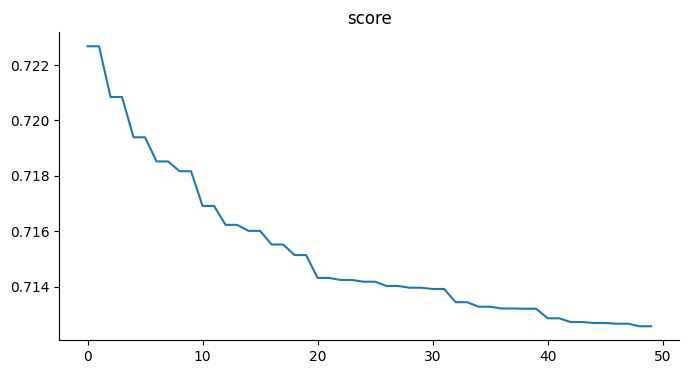

In [ ]:
from matplotlib import pyplot as plt
_df_4['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

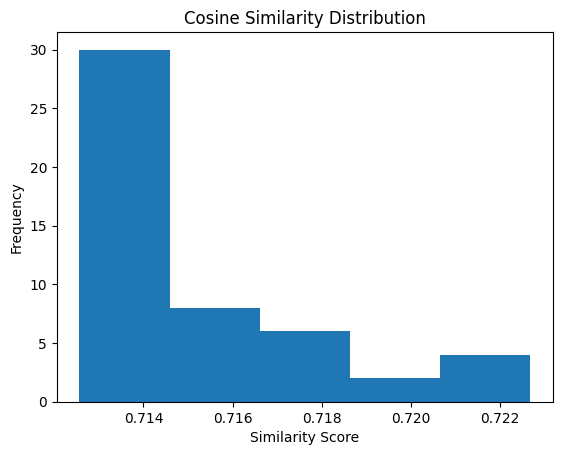

In [ ]:
plt.hist(results["score"], bins=5)
plt.title("Cosine Similarity Distribution")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()